In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os

#thanks Muammar 
PAD_ix=-1

# Problem & Dataset

* We solve a problem of transribing english words.
* word (sequence of letters) -> transcipt (sequence of phonemes)
* The problem is, some letters correspond to several phonemes and others - to none.
* We solve it through encoder-decoder recurrent neural networks
* This architecture is generally about converting ANY sequence into ANY other sequence. It could even become president one day.

In [2]:
with open("./train.csv") as fin:
    ids,words,transcripts = zip(*[line.split(',') for line in list(fin)[1:]])
    words = [word+"@" for word in words]
    transcripts = [["START"]+ts[:-2].split()+["END"] for ts in transcripts]

In [3]:
phonemes = list(set([token for ts in transcripts for token in ts]))
phoneme_to_ix = {ph:i for i,ph in enumerate(phonemes)}

In [4]:
letters = list(set([token for word in words for token in word]))
letter_to_ix = {l:i for i,l in enumerate(letters)}

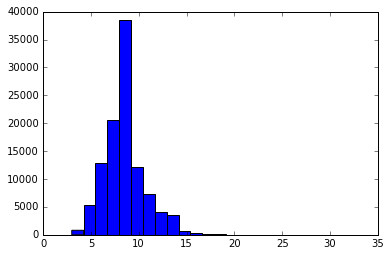

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(map(len,transcripts),bins=25);

# truncate names longer than MAX_LEN characters. 
MAX_LEN = min([60,max(list(map(len,transcripts)))])
#ADJUST IF YOU ARE UP TO SOMETHING SERIOUS


### Cast everything from symbols into matrix of int32. Pad with -1

In [6]:
def as_matrix(sequences,token_to_i, max_len=None,PAX_ix=PAD_ix):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int8') -1
    for i,seq in enumerate(sequences):
        row_ix = map(token_to_i.get,seq)[:max_len]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


In [7]:
print as_matrix(words[:10],letter_to_ix)

[[32 37 36 47 45 30 35 35 26 23 -1 -1 -1 -1 -1]
 [34 36 45 30 26 28 36 30 37 28 23 -1 -1 -1 -1]
 [39 31 36 43 36 40 46 37 43 31 26 40 30 40 23]
 [27 26 35 30 36 23 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [40 44 30 45 26 35 26 27 23 -1 -1 -1 -1 -1 -1]
 [45 22 37 35 30 26 44 23 -1 -1 -1 -1 -1 -1 -1]
 [35 30 37 27 26 34 22 37 23 -1 -1 -1 -1 -1 -1]
 [25 22 41 28 26 41 23 -1 -1 -1 -1 -1 -1 -1 -1]
 [31 30 37 32 40 36 37 23 -1 -1 -1 -1 -1 -1 -1]
 [27 42 26 43 23 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


# Input variables

In [8]:
input_sequence = T.matrix('token sequence','int32')
target_phonemes = T.matrix('target phonemes','int32')


# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [9]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [10]:

##ENCODER
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)
l_mask = lasagne.layers.InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1))
l_emb = lasagne.layers.EmbeddingLayer(l_in, len(letters), 40)
l_rnn = lasagne.layers.GRULayer(l_emb,256,only_return_final=True,mask_input=l_mask)

##DECODER
transc_in = lasagne.layers.InputLayer(shape=(None, None),input_var=target_phonemes)
transc_mask = lasagne.layers.InputLayer(shape=(None, None),input_var=T.neq(target_phonemes,-1))
transc_emb = lasagne.layers.EmbeddingLayer(transc_in, len(phonemes), 50)
transc_rnn = lasagne.layers.GRULayer(transc_emb,256,hid_init=l_rnn,mask_input=transc_mask)


#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
transc_rnn_flat = lasagne.layers.reshape(transc_rnn, (-1,transc_rnn.output_shape[-1]))

l_out = lasagne.layers.DenseLayer(transc_rnn_flat,len(phonemes),nonlinearity=lasagne.nonlinearities.softmax)



In [11]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print weights

[W, W, W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate, W_in_to_hidden_update, W_hid_to_hidden_update, b_hidden_update, W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate, W_in_to_hidden_update, W_hid_to_hidden_update, b_hidden_update, W, b]


In [12]:
network_output = lasagne.layers.get_output(l_out)
network_output = network_output.reshape([target_phonemes.shape[0],target_phonemes.shape[1],-1])
#If you use dropout do not forget to create deterministic version for evaluation

In [14]:
predictions_flat = network_output[:,:-1,:].reshape([-1,len(phonemes)])
targets = target_phonemes[:,1:].ravel()

#do not count loss for '-1' tokens
mask = T.nonzero(T.neq(targets,-1))

loss = T.nnet.categorical_crossentropy(predictions_flat[mask],targets[mask])


updates = lasagne.updates.adam(loss.mean(),weights)

# Compiling it

In [15]:

#training
train = theano.function([input_sequence, target_phonemes], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_phonemes], loss, allow_input_downcast=True)


# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [16]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
network_output = network_output.reshape((target_phonemes.shape[0],target_phonemes.shape[1],len(phonemes)))
#predictions for next tokens (after sequence end)
last_word_probas = network_output[:,-1]
probs = theano.function([input_sequence,target_phonemes],last_word_probas,allow_input_downcast=True)


In [23]:
def generate_transcript(word,transcript_prefix = ("START",),t=1,sample=True):
    
    transcript = list(transcript_prefix)
    while True:
        
        next_phoneme_probs = probs(as_matrix([word],letter_to_ix),as_matrix([transcript],phoneme_to_ix) ).ravel()
        next_phoneme_probs = next_phoneme_probs**t / np.sum(next_phoneme_probs**t)

        if sample:
            next_phoneme = np.random.choice(phonemes,p=next_phoneme_probs) 
        else:
            next_phoneme = phonemes[np.argmax(next_phoneme_probs)]

        transcript.append(next_phoneme)

        if next_phoneme=="END":
            break
    return transcript

In [25]:
generate_transcript("OLOLO@")

['START', 'SH', 'P', 'IY', 'AH', 'Z', 'Z', 'START', 'B', 'OW', 'END']

# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



# Умная мысля 2
Имеет смысл не брать случайные слова, а сэмплить более качественно
1) перемешаем номера примеров
2) проходим по первым 100(batch_size) примерам, потом по вторым 100 ... и так до конца выборки

повторять до победы

In [26]:
words = np.array(words)
transcripts = np.array(transcripts)

In [27]:
def sample_batch(words,transcripts, batch_size):
    
    batch_ix = np.random.randint(0,len(words),size=batch_size)
    words_batch=as_matrix(words[batch_ix],letter_to_ix) 
    transcripts_batch=as_matrix(transcripts[batch_ix],phoneme_to_ix)
    return words_batch,transcripts_batch

In [28]:

!pip install tqdm
from tqdm import tqdm

    100% |████████████████████████████████| 51kB 1.8MB/s 


In [29]:


print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):


    avg_cost = 0;
    
    for _ in tqdm(range(batches_per_epoch)):
        
        x,y = sample_batch(words,transcripts,batch_size)
        avg_cost += train(x, y).mean()
        
        
    
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    for i in range(5):
        ind = np.random.randint(len(words))
        print words[ind],':', ' '.join(generate_transcript(words[ind],sample=False)[1:-1])



  0%|          | 1/500 [00:00<00:50,  9.97it/s]

Training ...


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 average loss = 2.67409567991
AMMANN@ : T AE N T AH N
CAREMARK'S@ : K R AE K AH L AH N
LONELINESS@ : K AH N S AH N Z
SHEILS@ : R AY D
VERBALLY@ : F R AE K AH L


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 average loss = 1.96144024289
CLAUDINA@ : L AE K S AH N Z
SMITH@ : S T AE M
BENIGNA@ : B IH NG G AH N
MUTCH@ : M OW T
HANDIER@ : HH AE N D ER


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2 average loss = 1.52832217091
ORDAINING@ : AA R AH L IH NG
HOVERS@ : HH AE T ER Z
CHATIHACHI@ : CH AE CH AH JH IY
CREDITABLE@ : K R IY V AH B AH L
UNTREATED@ : AH N T ER B AH L D


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3 average loss = 1.26334943656
GOEDERT@ : G AA D ER T
FRANCORP@ : F R AA N T ER
HOEPNER@ : HH AA P ER N
NYBORG@ : N AA B AA R OW
SPROUTAPHILE@ : S P R OW F AH L T IH Z


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4 average loss = 1.0987205949
BEDORE@ : B EH D R OW
MODALITIES@ : M AH D AH L T IH K S
GALLER@ : G AE L ER
SHASHLIK@ : SH AE S K AH L
DUSTMAN@ : D AH S T AH M


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5 average loss = 0.962769228037
HOLMQUIST@ : HH OW L M P R IY T S
STRESSES@ : S T R EH S IH Z
WHARF@ : W AO R F
BEHRENS@ : B ER G N Z
INCANT@ : IH N K AE N T


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6 average loss = 0.877662117702
GOTSHALL@ : G AA T W AH L
DANBY@ : D AE N B IY
INNATE@ : IH N EY T IY
TRUMBLE@ : T R AE M B AH L
CONTINGENCIES@ : K AA N T IH N AH T IH N S


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7 average loss = 0.797939463123
BOUT@ : B OW T
WIKLUND@ : W IH K L AH N D
DARLEY@ : D AA R L IY
TISHER@ : T AY SH ER
SEEM@ : S IY M


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8 average loss = 0.718155919214
SHIFLETT@ : SH IH P L IH T
PENSINGER@ : P EH N S IH NG ER
GRAND'S@ : G R AE N D Z
TEENA@ : T IY N AH
MCLARTY@ : M AH K L AE R T


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9 average loss = 0.685070049355
XERISCAPE@ : S EH R IH S K EH P T AH
LUMA@ : L UW M AH
HOUSHOLDER@ : HH AW S HH AA L D ER
DILIBERTO@ : D IH L IH B ER T OW
DOKELY@ : D AA K AH L IY


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10 average loss = 0.644432581514
REVERSIBLE@ : R IH V ER S IY V
UY@ : Y UW
JAMMU'S@ : JH AE M AH S
PRESIDENTS@ : P R EH Z IH D AH N T S
LABOV@ : L AH B AA V


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11 average loss = 0.600716521165
TIMUR@ : T IH M ER
DESCHNER@ : D EH S M ER N
GATZKE@ : G AE T S K IY
BISSON@ : B IH S AH N
CORNUCOPIA@ : K AO R N CH AA K OW


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12 average loss = 0.589344962053
CAPTAINING@ : K AE P AH N IH NG
MONARCHY@ : M AA N ER IY
HAGIOGRAPHY@ : HH AE G AH G AO R IY AH
TEICHMANN@ : T IH K M AH N
LUCENT@ : L UW S AH N T


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13 average loss = 0.560619344801
CYNRIC@ : S IH N R IH K
FARLEY@ : F AA R L IY
AY@ : EY
BELLINO@ : B EH L IY N OW
ENTREATY@ : EH N T R IY T IY


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14 average loss = 0.528267260163
OVERMYER@ : OW V ER M AY ER
NEWCOM@ : N UW K AH M
SCRUNCHED@ : S K R AH N CH T
BOECKMANN@ : B OW K M AH N
TED@ : T EH D


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15 average loss = 0.515511607462
CLEMMER@ : K L EH M ER
OXIDIZE@ : AA K S AH D AY Z D
VASBINDER@ : V AE S B IH N D ER
ARBOTHNOTT@ : AA R B AA N T AE K T
DIVERSIFYING@ : D IH V ER S IH F IH NG


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16 average loss = 0.501669207193
PACKET@ : P AE K AH T
INVERNESS@ : IH N V ER N AH S
BONSER@ : B AA N S ER
GRUETZMACHER@ : G R UW T S K AA R
FIELDCREST@ : F IY L D ER S T


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17 average loss = 0.490789649643
NOAH'S@ : N OW HH AA Z
MARR@ : M AA R
SIEWIOREK@ : S IY W ER IY
SIMULATING@ : S IH M Y AH L EY T IH NG
ENERGIZER@ : IH N ER JH AY ER Z


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18 average loss = 0.47286780201
RECESSION@ : R IH S EH SH AH N
KENNARD@ : K EH N ER D
LIVESTOCK@ : L IH V IH S T AE K
ROGSTAD@ : R AA G S T AE D
TELECTRON@ : T EH L AH T R OW N


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19 average loss = 0.463484897078
NEWBROUGH@ : N UW B R OW
D'ELECTRICITE@ : D IY L EH K T R IH K T IY
ALTAMONT@ : AE L T AH M AH N T
LOUISVILLE@ : L UW IH S AH V AH L
MERCHANDISERS@ : M ER K AH N D AY Z ER Z


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20 average loss = 0.444196355364
VAILE@ : V EY L
MAHLMAN@ : M AA L M AH N
SCHLESSINGER@ : SH L EH S IH N JH ER
LANDHOLDING@ : L AE N D HH OW L D IH NG
MONTBLANC@ : M AA N T B AE K S AH N


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 21 average loss = 0.438115408187
VIRINA@ : V IH R IY N AH
PODOLSKY@ : P OW D AA L S K IY
GYPPED@ : JH IH P T
STEAMY@ : S T IY M IY
ANACOMP@ : AE N AH K AA M P


 29%|██▉       | 147/500 [00:12<00:26, 13.44it/s]

KeyboardInterrupt: 

In [47]:
generate_transcript(("zeppelin"+"@").upper())

['START', 'S', 'IY', 'F', 'S', 'IH', 'L', 'AH', 'N', 'END']

# And now,
* try lstm/gru
* try several layers
* try mtg cards
* try your own dataset of any kind